# 1. Метрики ранжирования

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from surprise import Dataset

https://habr.com/ru/company/econtenta/blog/303458/

### Метрики ранжирования для бинарных предпочтений

### 1.1 MAP

$\textbf{Precision at K (p@K)}$ - точность на K элементах

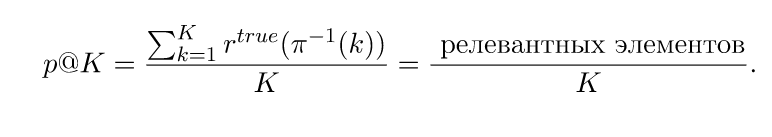

$\textbf{Average precision at K (ap@K)}$ - сумма p@k по индексам k от 1 до K только для релевантных элементов, деленая на K

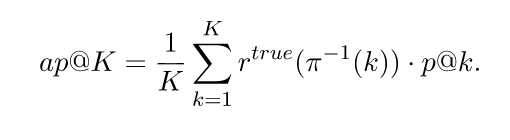

$\textbf{Mean average precision at K (map@K)}$ - среднее значение ap@K по всем объектам

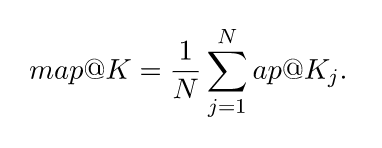

In [2]:
def p_k(true, predicted, K):
    """
    true - np.array() with the shape (M,) with true relevances(binarized) of items for one user
    predicted - np.array() with the shape (M,) with predicted relevances of items for one user
    
    """
    pred_order = np.argsort(predicted)[::-1]
    return np.mean([true[pred_order[i]] for i in range(K)])

In [3]:
def ap_k(true, predicted, K):

    pred_order = np.argsort(predicted)[::-1]
    return np.mean([true[pred_order[k-1]]* p_k(true, predicted, k) for k in range(1, K+1)])

In [4]:
def map_k(true, predicted, K):
    """ 
    N - users, M - items

    """
    return np.mean([ap_k(true[i],predicted[i],K) for i in range(true.shape[0])])

In [5]:
t = np.array([[1,0,0,1,1,1,0],[1,1,0,0,1,1,0]])

p = np.array([[0.3,0.2,0.9,0.8,0.7,0.3,0.1],[0.2,0.8,0.1,0.2,0.4,0.3,0.1]])

map_k(t,p,3)

0.6944444444444444

### 1.2 MRR

$\textbf{Reciproсal rank (RR@K)}$ - обратный ранк первого правильно угаданного элемента среди первых K

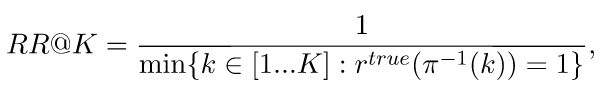

$\textbf{ Mean reciprocal rank (MRR)}$ - среднее значение RR@K по всем объектам

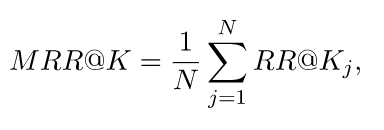

In [6]:
def rr_k(true, predicted, K):
    pred_order = np.argsort(predicted)[::-1]
    for j in range(K):
        if true[pred_order[j]] == 1:
            return 1 / (1+j)
    return 1 / len(predicted) 

In [7]:
def mrr_k(true, predicted, K):
    return np.mean([rr_k(true[i],predicted[i], K) for i in range(true.shape[0])])

In [8]:
t = np.array([[1,0,0,1,1,1,0],[1,1,0,0,1,1,0]])

p = np.array([[0.3,0.2,0.9,0.8,0.7,0.3,0.1],[0.2,0.8,0.1,0.2,0.4,0.3,0.1]])

mrr_k(t,p,3)

0.75

### 1.3 nDCG

$\textbf{Cumulative gain at K (CG@K)}$. Может использоваться и в случае небинарных значений эталонной релевантности $r^{true}$.

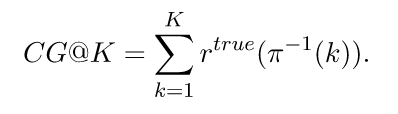

$\textbf{Discounted cumulative gain at K (DCG@K)}$ . Учитывает порядок элементов в списке путем домножения релевантности элемента на вес равный обратному логарифму номера позиции

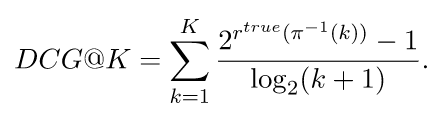

В бинарном случае 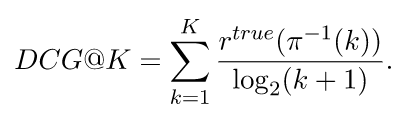

$\textbf{Normalized discounted cumulative gain at K (nDCG@K)}$

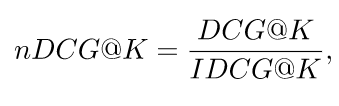

$IDCG@K$ - это максимальное (I — ideal) значение $DCG@K$. В случае, когда $r^{true}\in \{0,1\}$

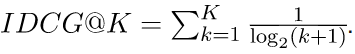

In [9]:
def dcg(true, predicted):
    pred_order = np.argsort(predicted)[::-1]
    return np.sum([(np.power(2, true[pred_order[i]]) - 1) / np.log2(i + 2) for i in range(len(true))])

def dcg_k(true, predicted, K):
    pred_order = np.argsort(predicted)[::-1]
    return np.sum([(np.power(2, true[pred_order[i]]) - 1) / np.log2(i + 2) for i in range(K)])

def ideal_dcg(true):
    sorted_order = sorted(true)[::-1]
    return np.sum([(np.power(2, sorted_order[i]) - 1) / np.log2(i + 2) for i in range(len(true))])

def ideal_dcg_k(true, K):
    sorted_order = sorted(true)[::-1]
    return np.sum([(np.power(2, sorted_order[i]) - 1) / np.log2(i + 2) for i in range(K)])

def ndcg(true, predicted):
    return dcg(true, predicted) / ideal_dcg(true)

def ndcg_k(true, predicted, K):
    return dcg_k(true, predicted, K) / ideal_dcg_k(true, K)


def delta_ndcg(true, predicted, i, j):
    tr = true.copy()
    buf = tr[i]
    tr[i] = tr[j]
    tr[j] = buf
    return ndcg(true, predicted) - ndcg(tr, predicted)

In [10]:
t = np.array([0.9,0.4,0.2,0.5,0.8,0.2,0.4])

p = np.array([0.2,0.5,0.3,0.6,0.9,0.1,0.2])

In [11]:
ndcg(t, p)

0.8967743050331934

In [12]:
ndcg_k(t, p, 5)

0.7490933272202829

In [13]:
t = np.array([1,0,0,1,1,0,0])

p = np.array([0.2,0.5,0.3,0.6,0.9,0.1,0.2])

ndcg_k(t, p, 5)

0.7653606369886217

# 2. LambdaMart

https://ffineis.github.io/blog/2021/05/01/lambdarank-lightgbm.html

### Загрузка данных

In [14]:
train = pd.read_csv("MQ2007/Fold1/train.txt", sep = " ", header = None)    

test = pd.read_csv("MQ2007/Fold1/test.txt", sep = " ", header = None) 

In [15]:
def f(a):
    if a[1] == ":":
        return float(a[2:])
    if a[2] == ":":
        return float(a[3:])
for i in tqdm(range(2,48)):
    train[i] = train.apply(lambda x: f(x[i]), axis =  1)
    
for i in tqdm(range(2,48)):
    test[i] = test.apply(lambda x: f(x[i]), axis =  1)

100%|███████████████████████████████████████████| 46/46 [00:04<00:00,  9.27it/s]


In [16]:
def f1(a):
    return float(a[4:])
train[1] = train.apply(lambda x: f1(x[1]), axis =  1)

test[1] = test.apply(lambda x: f1(x[1]), axis =  1)

In [17]:
train = train.drop(columns = [48,49,50,51,52,54,55])

train = train.rename(columns ={0:'relevance', 1: 'qid', 53: 'inc', 56:'prob'})

a = dict()
for i in range(2,48):
    a[i] = str(i)
    
train = train.rename(columns = a)

test = test.drop(columns = [48,49,50,51,52,54,55])

test = test.rename(columns ={0:'relevance', 1: 'qid', 53: 'inc', 56:'prob'})

a = dict()
for i in range(2,48):
    a[i] = str(i)
    
test = test.rename(columns = a)

In [18]:
train = train.drop(columns = ['inc', 'prob'])

In [19]:
test = test.drop(columns = ['inc', 'prob'])

In [20]:
train.head()

,relevance,qid,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0,10.0,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.000000,0.0
1,1,10.0,0.031310,0.666667,0.50,0.166667,0.033206,0.0,0.0,0.0,...,0.646890,0.686107,0.823908,0.750092,0.385426,0.923077,0.086207,0.333333,0.448276,0.0
2,1,10.0,0.078682,0.166667,0.50,0.333333,0.080022,0.0,0.0,0.0,...,0.649824,0.578581,0.868557,0.641385,0.010462,0.076923,0.074713,0.833333,0.678161,0.0
3,1,10.0,0.019058,1.000000,1.00,0.500000,0.022591,0.0,0.0,0.0,...,0.918403,0.868457,1.000000,0.863460,0.016642,0.153846,0.040230,0.833333,0.896552,0.0
4,0,10.0,0.039477,0.000000,0.75,0.166667,0.040555,0.0,0.0,0.0,...,0.565875,0.569440,0.769845,0.646567,0.073711,0.076923,0.034483,0.333333,0.218391,0.0


### Реализация алгоритма на основе решающих деревьев

Идея алгоритма: Построим лосс, который получается из logloss домножением на $\Delta nDCG$, градиент которого обозначаем $\lambda$. Затем применим подход градиентного бустинга: построим фиксированное количество деревьев, каждое из которых будет предсказывать $\lambda$ - величину шага для градиентного спуска при минимизации нашего лосса.

In [21]:
from sklearn.tree import DecisionTreeRegressor

In [22]:
def get_true_pairs(true):
    pairs = []
    for i in range(len(true)):
        for j in range(len(true)):
            if true[i] > true[j]:
                pairs.append((i,j))
    return pairs

In [23]:
class LambdaMART:
    def __init__(self, training_data, n_trees = 10, max_depth = 5, learning_rate = 0.1):
        """ 
        training_data - pd.Dataframe of features with column qid - номер объекта
        строчки с одним qid - рекомендации для одного объекта
        колонка relevance - ответ алгоритма
        """
        self.training_data = training_data
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.trees = []
        
    def compute_lambda(self, true_scores, predicted_scores):

        lambdas = np.zeros(len(true_scores))
        
        for i,j in get_true_pairs(true_scores):
            d_ndcg = abs(delta_ndcg(true_scores, predicted_scores, i, j))
            rho = 1 / (1 + np.exp(predicted_scores[i] - predicted_scores[j]))
            rho_complement = 1.0 - rho
            lambda_val = d_ndcg * rho
            lambdas[i] += lambda_val
            lambdas[j] -= lambda_val

        return lambdas 
    
    def fit(self):
        
        for k in tqdm(range(self.n_trees)):
            Predicted_Scores = pd.Series(0, index = self.training_data.index)
            lambdas = []
            for q in self.training_data.qid.unique():
    
                true_scores = np.asarray(self.training_data.relevance[self.training_data.qid == q])
                predicted_scores = np.asarray(Predicted_Scores[self.training_data.qid == q])
            
                lambdas_ = self.compute_lambda(true_scores, predicted_scores)
                lambdas.append(lambdas_)
                
            lambdas = np.hstack(lambdas)
            
            tree = DecisionTreeRegressor(max_depth = self.max_depth)
            tree.fit(self.training_data.drop(columns = ['relevance','qid']), lambdas)
            self.trees.append(tree)
                     
            prediction = tree.predict(self.training_data.drop(columns = ['relevance','qid']))
            Predicted_Scores += prediction * self.learning_rate
            

    def predict(self, data):        
        results = np.zeros(len(data))
        for tree in self.trees:
            results += self.learning_rate * tree.predict(data)
        return results

In [24]:
lambdamart = LambdaMART(train, n_trees = 10, max_depth = 5, learning_rate = 0.1)

In [25]:
lambdamart.fit()

100%|██████████████████████████████████████████| 10/10 [34:53<00:00, 209.31s/it]


# 3. Протестируем алгоритм и посчитаем метрики из п. 1 

### Сформируем предсказания

In [26]:
preds_train = lambdamart.predict(train.drop(columns = ['relevance','qid']))

In [27]:
preds_test = lambdamart.predict(test.drop(columns = ['relevance','qid']))

### Подсчёт метрик

In [28]:
K = 5

In [29]:
NDCG_train = []
for i in np.unique(train.qid):
    if len(np.unique(train.relevance[train.qid == i].values)) > 1:  # nDCG не определён, если все true relevance = 0 
        NDCG_train.append(ndcg_k(train.relevance[train.qid == i].values, preds_train[train.qid == i], K))

In [30]:
print(np.mean(NDCG_train))  # средний nDCG@5 по всем объектам на train

0.45256568218354126


In [31]:
NDCG_test = []
for i in np.unique(test.qid):
    if len(np.unique(test.relevance[test.qid == i].values)) > 1:  # nDCG не определён, если все true relevance = 0 
        NDCG_test.append(ndcg_k(test.relevance[test.qid == i].values, preds_test[test.qid == i],K))

In [32]:
print(np.mean(NDCG_test)) # средний nDCG@5 по всем объектам на test

0.47586180342906775


In [33]:
AP_train = []
for i in np.unique(train.qid):
    AP_train.append(ap_k(train.relevance[train.qid == i].values, preds_train[train.qid == i], K))

In [34]:
print(np.mean(AP_train))  #  MAP@5 на train

0.5696722386102917


In [35]:
AP_test = []
for i in np.unique(test.qid):
    AP_test.append(ap_k(test.relevance[test.qid == i].values, preds_test[test.qid == i], K))

In [36]:
print(np.mean(AP_test)) #  MAP@5 на test

0.6414186507936508


In [37]:
RR_train = []
for i in np.unique(train.qid):
    RR_train.append(rr_k(train.relevance[train.qid == i].values, preds_train[train.qid == i], K))

In [38]:
print(np.mean(RR_train)) #  MRR@5 на train

0.4162252254397916


In [39]:
RR_test = []
for i in np.unique(test.qid):
    RR_test.append(rr_k(test.relevance[test.qid == i].values, preds_test[test.qid == i], K))

In [40]:
print(np.mean(RR_test)) #  MRR@5 на test

0.41949104230672773


#### Вывод:
Можем наблюдать, что средний начения метрик на тесте даже превосходят значения на трейне, что свидетельсвтует о том, что модель недообучилась, слишком маленькое количество деревьев(10) было использовано при построении LambdaMart

### 4. Применим алгоритм LambdaMart к дастасэту movielens

In [24]:
data = Dataset.load_builtin('ml-100k')
df = pd.DataFrame(data.raw_ratings)
df.columns = ['user', 'item', 'rating', 'timestamp']
df.drop(columns = 'timestamp', inplace = True)

In [25]:
df.head()

,user,item,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


Для использования LambdaMart нужны признаки, давайте воспользуемся knn из hw1: получим матрицу рейтингов каждого юзера для каждого фильма. Добавим для каждого юзера в качестве признака усреднённый рейтинг его k соседей  

In [26]:
def euclidean_distance(x, y):
    u = np.diagonal((x @ x.T)).reshape(x.shape[0], 1)   # квадраты векторов из матрицы x
    v = np.diagonal(y @ y.T).reshape(1, y.shape[0])     # квадраты векторов из матрицы y
    # приводим к нужной размерности, так как на выходе должна быть матрица попарных расстояний
    u = u @ np.ones(y.shape[0]).reshape(1, y.shape[0])
    v = np.ones(x.shape[0]).reshape(x.shape[0], 1) @ v
    return np.sqrt(u + v - 2*(x @ y.T))  # вычитаем попарные скалярные произведения векторов из x и векторов из y


def cosine_distance(x, y): # 1- cos(x,y); cos(x,y) = (x,y)/|x||y|
    u = np.sqrt(np.diagonal((x @ x.T)).reshape(x.shape[0], 1))  # длины векторов из матрицы x
    v = np.sqrt(np.diagonal(y @ y.T).reshape(1, y.shape[0]))    # длины векторов из матрицы y
    # приводим к нужной размерности, так как на выходе должна быть матрица попарных расстояний
    u = u @ np.ones(y.shape[0]).reshape(1, y.shape[0])
    v = np.ones(x.shape[0]).reshape(x.shape[0], 1) @ v
    return 1 - x @ y.T / u / v          # делим скалярные произведения векторов их на длины

class Knn:
    def __init__(self, k = 10, min_k = 1, similarity='cosine', mode = 'user_based'):
        if similarity == 'euclidean':
            self.simil = euclidean_distance
        elif similarity == 'cosine':
            self.simil = cosine_distance
        else:
            raise ValueError("Metric is not supported", similarity)
        if mode not in ('user_based', 'item_based'):
            raise ValueError("Algorithm mode is not supported", mode)
            
        self.k = k
        self.min_k = min_k
        self.similarity = similarity
        self.mode = mode
        self.test_split_flag = False
        self.eps = 1e-5
    
    def fit(self, X):
         
        self.R = X.pivot(index='user', columns='item', values='rating').fillna(0).values
    
    def train_test_split(self, test_size = 10): # test_size количество объектов, для каждого пользователя, рейтинги которых делаем нанами
        self.test_split_flag = True
        
        def make_test(a):
            notnans = np.argwhere(a > 0).reshape(-1)
            # выберем по 10 not nan значений из кажой строки
            notnans_sample = np.random.randint(0, int(len(notnans)), size = test_size)
            return notnans[notnans_sample]  # возвращаем индексы выбранных значений
        
        self.test_split = np.apply_along_axis(make_test, 1, self.R)    
        self.test_ratings = np.take_along_axis(self.R, self.test_split, 1)
        
        for i in range(len(self.R)):  # формируем обучающую выборку, заполняя выбранные ранее элементы нулями
            self.R[i][self.test_split[i]] = 0
            
        
        if self.mode == 'user_based':
            self.users_mean_rating = np.mean(self.R, axis = 1)
        if self.mode == 'item_based':
            self.items_mean_rating = np.mean(self.R, axis = 0)
            
        #  проверим, что нет таких объектов и пользователей, у которых вообще нет оценок после создания тестовой выборки 
        if self.mode == 'user_based':
            for i in range(self.R.shape[0]):
                if self.R[i,:].sum() == 0:
                    self.R[i,:] = self.R.mean()    
        if self.mode == 'item_based':
            for i in range(self.R.shape[1]):
                if self.R[:,i].sum() == 0:
                    self.R[:,i] = self.R.mean()      
        

    def kneighbors(self):  
        distances = self.simil(self.R, self.R)
        if self.similarity == 'cosine':
            similarities = 1 - distances
        if self.similarity == 'euclidean':
            similarities = 1 / (self.eps + distances) 
        indices = np.argsort(distances, axis = 1)  
        
        return similarities, indices[:,1:]  # не учитываем, что сам объект является ближайшим к самому себе 

    def predict(self): 
        if self.mode == 'item_based':
            self.R = self.R.T
        similarities, indices = self.kneighbors()
        self.indices = indices
        self.count_rating(indices, similarities)
    
    def rmse(self):
        if self.test_split_flag:
            if self.mode == 'user_based':
                self.pred_test_ratings = np.take_along_axis(self.R, self.test_split, 1)
            if self.mode == 'item_based':
                self.pred_test_ratings = np.take_along_axis(self.R.T, self.test_split, 1)
            return np.mean((self.pred_test_ratings - self.test_ratings)**2)
        else:
            print("can't count mistake, as there is no test data")
            return np.NaN

### 1.1 KNNBasic

class KnnBasic(Knn):
    
    def count_rating(self, indices, similarities):
        for i in range(self.R.shape[1]):
            for u in range(self.R.shape[0]):
                if self.R[u,i] == 0:
                    j = 0
                    r = 0
                    const = 0
                    for v in indices[u]:
                        if  self.R[v,i] != 0:
                            r += similarities[u,v] * self.R[v,i]
                            const += similarities[u,v]
                            j += 1

                        if j == self.k:
                            break
                    if j < self.min_k:
                        if self.mode == 'user_based':
                            self.R[u,i] = self.users_mean_rating[u]
                        if self.mode == 'item_based':
                            self.R[u,i] = self.items_mean_rating[u]
                    else:
                        self.R[u,i] = r/const

In [27]:
model = KnnBasic(mode = 'user_based')
model.fit(df)
model.predict()

In [28]:
pivot = df.pivot(index='user', columns='item', values='rating')
pivot2 = pivot.reset_index()

In [29]:
datasets = []
for i in tqdm([3,5,7,10,15,20,50]):
    
    mean = []
    for indices in model.indices[:,:i]:
        mean.append(np.mean(model.R[indices], axis = 0))
    
    mean = pd.DataFrame(np.vstack(mean), columns = pivot2.columns[1:].to_list() )

    mean['user'] = pivot2.user.values

    datasets.append(pd.melt(mean, id_vars = 'user', value_name = 'mean rating k = '+str(i), value_vars = mean.columns[:-1].tolist()))
    

100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  6.71it/s]


In [30]:
for i in range(len(datasets)):
    datasets[i] = datasets[i].rename(columns ={'variable':'item'})

In [31]:
DataFrame = datasets[0]
for i in datasets[1:]:
    DataFrame = DataFrame.merge(i)

In [32]:
DataFrame = df.merge(DataFrame)

In [33]:
def rating(a):
    if a <= 3:
        return 0
    if a == 4:
        return 1
    if a == 5:
        return 2

DataFrame['relevance'] = DataFrame.apply(lambda x: rating(x['rating']), axis =  1)

In [34]:
DataFrame = DataFrame.rename(columns = {'user':'qid'})

In [50]:
DataFrame.head()

,qid,item,rating,mean rating k = 3,mean rating k = 5,mean rating k = 7,mean rating k = 10,mean rating k = 15,mean rating k = 20,mean rating k = 50,relevance
0,196,242,3.0,4.254951,4.206298,4.115011,4.247861,4.062487,4.065013,4.005482,0
1,186,302,3.0,4.323692,4.179590,4.157244,4.117937,4.016499,3.967037,4.128805,0
2,22,377,1.0,2.009654,2.174326,2.091281,2.028975,1.984403,1.921915,1.848849,0
3,244,51,2.0,4.333333,3.710676,3.650483,3.720885,3.655640,3.626387,3.609852,0
4,166,346,1.0,3.034051,3.025790,3.001018,2.987608,2.964101,3.004230,3.197066,0


In [46]:
DataFrame = DataFrame.iloc[:10000]

In [47]:
lambdamart = LambdaMART(DataFrame.drop(columns = ['rating','item']), n_trees = 10, max_depth = 5, learning_rate = 0.1)

In [48]:
lambdamart.fit()

100%|██████████████████████████████████████████| 10/10 [33:28<00:00, 200.84s/it]


In [52]:
preds_train = lambdamart.predict(DataFrame.drop(columns = ['rating','item','relevance','qid']))

In [56]:
K = 5

In [67]:
NDCG_train = []
for i in np.unique(DataFrame.qid):
    if len(np.unique(DataFrame.relevance[DataFrame.qid == i].values)) > 1:  # nDCG не определён, если все true relevance = 0 
        try:
            NDCG_train.append(ndcg_k(DataFrame.relevance[DataFrame.qid == i].values, preds_train[DataFrame.qid == i], K))
        except:
            continue
        
print(np.mean(NDCG_train))  # средний nDCG@5 по всем объектам на train

0.4635027383068058


https://neerc.ifmo.ru/wiki/index.php?title=%D0%A0%D0%B0%D0%BD%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5#:~:text=%D0%A0%D0%B0%D0%BD%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20(%D0%B0%D0%BD%D0%B3%D0%BB.,%D0%BD%D0%B0%20%D1%8D%D0%BB%D0%B5%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%85%20%D0%B2%D0%BD%D1%83%D1%82%D1%80%D0%B8%20%D0%BA%D0%B0%D0%B6%D0%B4%D0%BE%D0%B3%D0%BE%20%D1%81%D0%BF%D0%B8%D1%81%D0%BA%D0%B0.

$\textbf{Как адаптировать формат из "стандартных" датасэтов для ранжирования к задаче рекомендаций?}$
В датасете для ранжирования в качестве таргета содержатся оценки релевантности, чаще всего вероятности от 0 до 1. Эти вероятности можно разбить по квантилям определённых уровней, чтобы получить значения рейтингов(например, от 1 до 5), которые нужны в задаче рекомендации. Признаковое пространство для задач ранжирования состоит из пар (запрос, документ), считаем, что запрос - user, а документы в одном запросе - items

### 5. Сравним ранжирование из п. 4 с результатами работы SVD

In [71]:
class SVD:
    def __init__(self, n_factors = 10, n_epochs = 20, biased=True, 
                 init_mean=0, init_std_dev=0.1, lr_bu=1e-6, lr_bi=1e-6, lr_pu=1e-3, lr_qi=1e-3,
                 reg_bu=0, reg_bi=0, reg_pu=0.1, reg_qi=0.1):

        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.biased = biased
        self.init_mean = init_mean
        self.init_std_dev = init_std_dev
        self.lr_bu = lr_bu
        self.lr_bi = lr_bi
        self.lr_qi = lr_qi
        self.lr_pu = lr_pu
        self.reg_pu = reg_pu
        self.reg_qi = reg_qi
        self.reg_bu = reg_bu
        self.reg_bi = reg_bi
        self.test_split_flag = False
    
    def fit(self, X):             
        self.R = X.pivot(index='user', columns='item', values='rating').fillna(0).values
    
    def train_test_split(self, test_size = 10): # test_size количество объектов, для каждого пользователя, рейтинги которых делаем нанами
        self.test_split_flag = True
        def make_test(a):
            notnans = np.argwhere(a > 0).reshape(-1)
            # выберем по 10 not nan значений из кажой строки
            notnans_sample = np.random.randint(0, int(len(notnans)), size = test_size)
            return notnans[notnans_sample]  # возвращаем индексы выбранных значений
        
        self.test_split = np.apply_along_axis(make_test, 1, self.R)    
        self.test_ratings = np.take_along_axis(self.R, self.test_split, 1)
        
        for i in range(len(self.R)):  # формируем обучающую выборку, заполняя выбранные ранее элементы нулями
            self.R[i][self.test_split[i]] = 0    
 
        #  проверим, что нет таких пользователей, у которых вообще нет оценок после создания тестовой выборки 
        for i in range(self.R.shape[0]):
            if self.R[i,:].sum() == 0:
                self.R[i,:] = self.R.mean()    
    
    def predict(self): 
        self.users_mean_rating = np.mean(self.R, axis = 1)
        self.items_mean_rating = np.mean(self.R, axis = 0)
        self.mean = self.R.mean()
        self.solver()
        self.R = self.R_est
   
    def rmse(self):
        if self.test_split_flag:
            self.pred_test_ratings = np.take_along_axis(self.R, self.test_split, 1)
            return np.mean((self.pred_test_ratings - self.test_ratings)**2)
        else:
            print("can't count mistake, as there is no test data")
            return np.NaN

In [72]:
class SVD_SGD(SVD):
    def solver(self):
        self.P = self.init_mean + self.init_std_dev * np.random.randn(self.R.shape[0], self.n_factors)
        self.Q = self.init_mean + self.init_std_dev * np.random.randn(self.n_factors, self.R.shape[1])
        if self.biased:
            self.R_est = self.mean + self.users_mean_rating.reshape(-1,1) + self.items_mean_rating.reshape(1,-1) + self.P @ self.Q
            for j in range(self.n_epochs):
                for u in np.random.permutation(range(self.R.shape[0])):
                    for i in np.random.permutation(range(self.R.shape[1])):
                        if self.R[u,i] != 0:
                            self.users_mean_rating = self.users_mean_rating + self.lr_bu * (self.R[u,i] - self.R_est[u,i] - self.reg_bu * self.users_mean_rating)
                            self.items_mean_rating = self.items_mean_rating + self.lr_bi * (self.R[u,i] - self.R_est[u,i] - self.reg_bi * self.items_mean_rating)
                            self.P[u,:] = self.P[u,:] + self.lr_pu * ((self.R[u,i] - self.R_est[u,i]) * self.Q[:,i] - self.reg_pu * self.P[u,:])
                            self.Q[:,i] = self.Q[:,i] + self.lr_qi * ((self.R[u,i] - self.R_est[u,i]) * self.P[u,:] - self.reg_qi * self.Q[:,i])
                self.R_est = self.mean + self.users_mean_rating.reshape(-1,1) + self.items_mean_rating.reshape(1,-1) + self.P @ self.Q
        else:
            self.R_est = self.P @ self.Q
            for j in range(self.n_epochs):
                for u in np.random.permutation(range(self.R.shape[0])):
                    for i in np.random.permutation(range(self.R.shape[1])):
                        if self.R[u,i] != 0:
                            self.P[u,:] = self.P[u,:] + self.lr_pu * ((self.R[u,i] - self.R_est[u,i]) * self.Q[:,i] - self.reg_pu * self.P[u,:])
                            self.Q[:,i] = self.Q[:,i] + self.lr_qi * ((self.R[u,i] - self.R_est[u,i]) * self.P[u,:] - self.reg_qi * self.Q[:,i])
                self.R_est = self.P @ self.Q

На сравнение не хватило сил(

Но как бы я сравнивал качесвто: я бы перевёл результаты SVD(рейтинги) в шкалу релевантности:то есть то, что выше 3, но не больше 4 я бы перевёл в 1(релеватно), то, что выше 4 я бы перевёл в 2(очень релевантно), всё остальное - в 0(нерелеватно) )
А дальше бы посчитал MAP@K, nDCG@K и MRR

Можно было бы переводить рейтинги в значения релевантности по квантилям

Если рейтинги были бы по 10-балльной шкале. То всё, что меньше 7 - нерелеватно, от 7 до 9 - релевантно, а выше 9 - очень релевантно